<b> Importação de bibliotecas e funções <b>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

def read_input(fold='data/input/',filename=''):
    """
    Lê um arquivo CSV da pasta e nome de arquivo especificados.

    Args:
        fold (str, opcional): Pasta que contém o arquivo CSV. O valor padrão é 'data/input/'.
        filename (str, opcional): Nome do arquivo CSV. O valor padrão é ''.

    Returns:
        pd.DataFrame: Os dados lidos do arquivo CSV. Se o arquivo não existir ou não puder ser lido, um DataFrame vazio é retornado.

    Raises:
        Exception: Se ocorrer algum erro durante a leitura do arquivo.
    """
    try:
        return pd.read_csv(fold+filename)
    except:
        return pd.DataFrame()
    
def get_feature_importances(df, y, criterion="entropy"):
    """
    Calcula a importância de cada variável em um dataframe usando árvores de decisão.

    Args:
        df: Dataframe com as variáveis a serem avaliadas.
        y: Variável alvo.
        criterion: Critério de avaliação para a árvore de decisão.

    Returns:
        Lista com a importância de cada variável.
    """

    df = df.fillna(0)

    # Converta as colunas de string para variáveis dummy
    df_dummies = pd.get_dummies(df.select_dtypes(exclude=[np.number]))

    # Combine os DataFrames numérico e dummy
    df_combined = pd.concat([df.select_dtypes(include=[np.number]), df_dummies], axis=1)

    # Construa a árvore de decisão
    clf = DecisionTreeClassifier(criterion=criterion)
    clf.fit(df_combined, y)

    # Calcule a importância de cada variável
    importances = clf.feature_importances_
    print(importances)

    # Ordene as variáveis pela importância
    sorted_importances = np.argsort(importances)[::-1]

    # Converta as importâncias em porcentagem
    importances_percent = 100 * importances / importances.sum()

    # Retorne as variáveis mais relevantes
    return df_combined.columns[sorted_importances]

Leitura dos dados

In [2]:
fold_input = 'data/input/'
df_app_test = read_input(fold=fold_input,filename='application_test.csv')
df_app_train = read_input(fold=fold_input,filename='application_train.csv')
df_bureau = read_input(fold=fold_input,filename='bureau.csv')
df_bureau = read_input(fold=fold_input,filename='bureau.csv')

<b> Distribuição de pagamentos e inadimplencia </b>

Target: 

1 - cliente com dificuldades de pagamento: atrasou mais de X dias em pelo menos uma das primeiras Y parcelas do empréstimo da nossa amostra

0 - todos os demais casos

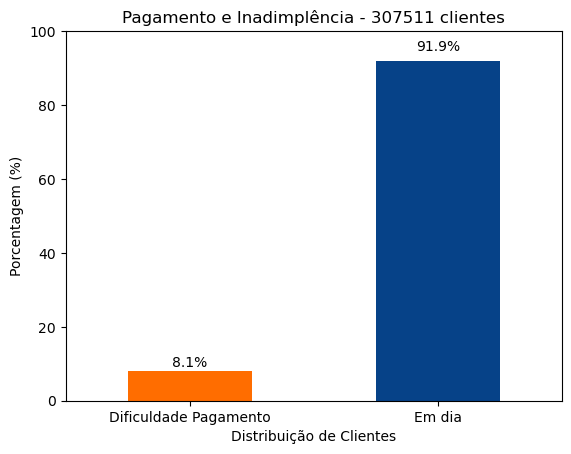

In [9]:
labels = ['Inadiplência', 'Quitado']
df_app_train_plot = df_app_train.copy()

df_app_train_plot['TARGET'] = df_app_train_plot['TARGET'].replace(1,'Dificuldade Pagamento')
df_app_train_plot['TARGET'] = df_app_train_plot['TARGET'].replace(0,'Em dia')

ax = df_app_train_plot['TARGET'].value_counts(normalize=True).mul(100).sort_values().plot(kind='bar',color=['#ff6d00','#064288'],rot=0)

for i, v in enumerate(ax.patches):
    ax.text(
        i,
        v.get_height() * 1.02,
        f"{v.get_height():.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.ylim([0,100])
plt.ylabel('Porcentagem (%)')
plt.xlabel('Distribuição de Clientes')
plt.title('Pagamento e Inadimplência - '+str(len(df_app_train))+' clientes')
plt.show()

<b> Relação target com o tipo de contrato </b>


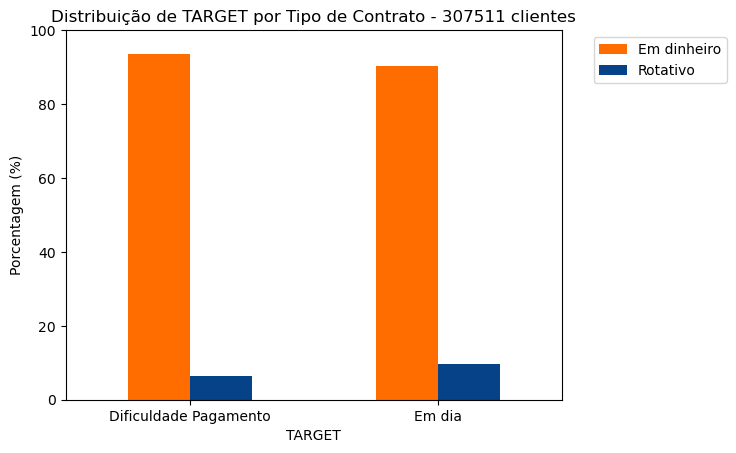

Contrato               Em dinheiro  Rotativo
Target                                      
Dificuldade Pagamento    93.538771  6.461229
Em dia                   90.209986  9.790014


In [33]:
# Criar um gráfico de barras empilhadas para cada tipo de contrato

df_app_train_plot['NAME_CONTRACT_TYPE'] = df_app_train_plot['NAME_CONTRACT_TYPE'].replace('Cash loans','Em dinheiro')
df_app_train_plot['NAME_CONTRACT_TYPE'] = df_app_train_plot['NAME_CONTRACT_TYPE'].replace('Revolving loans','Rotativo')

# Calcular a porcentagem em relação ao total por linha e Pivotar
grouped_df = df_app_train_plot.groupby(['TARGET', 'NAME_CONTRACT_TYPE']).size().reset_index(name='Contagem')
grouped_df.columns = ['Target','Contrato','Contagem']
pivot_df = grouped_df.pivot(index='Target', columns='Contrato', values='Contagem').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Criar um gráfico de barras empilhadas
ax = pivot_df.plot(kind='bar', stacked=False, color=['#ff6d00', '#064288'], rot=0)

plt.ylim([0, 100])
plt.ylabel('Porcentagem (%)')
plt.xlabel('TARGET')
plt.title('Distribuição de TARGET por Tipo de Contrato - ' + str(len(df_app_train)) + ' clientes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print(pivot_df)

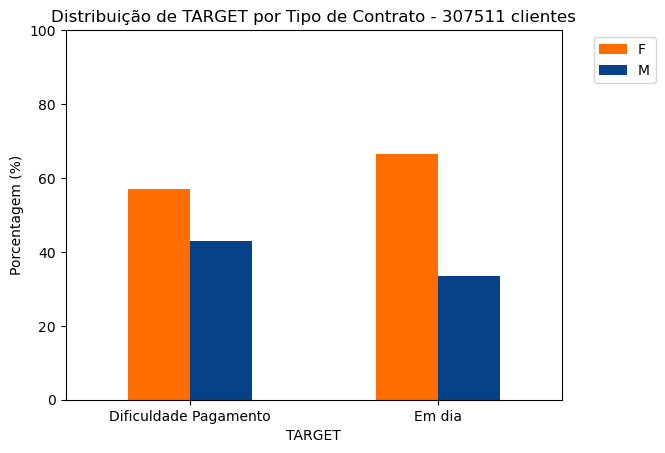

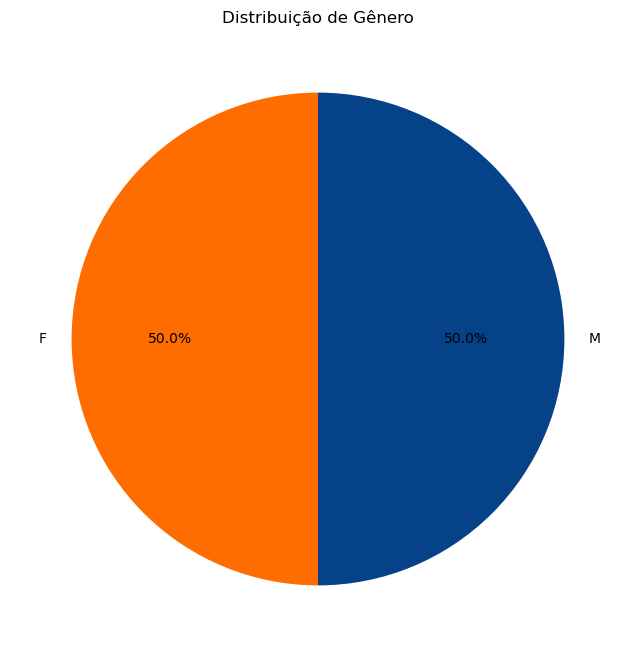

Gênero                         F          M
Target                                     
Dificuldade Pagamento  57.079557  42.920443
Em dia                 66.604170  33.395830


In [38]:
# Criar um gráfico de barras empilhadas para cada tipo de contrato


# Calcular a porcentagem em relação ao total por linha e Pivotar
grouped_df = df_app_train_plot.groupby(['TARGET', 'CODE_GENDER']).size().reset_index(name='Contagem')
grouped_df.columns = ['Target','Gênero','Contagem']
grouped_df = grouped_df[grouped_df['Gênero'].isin(['M','F'])]
pivot_df = grouped_df.pivot(index='Target', columns='Gênero', values='Contagem').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Criar um gráfico de barras empilhadas
ax = pivot_df.plot(kind='bar', stacked=False, rot=0,color=['#ff6d00', '#064288'])

plt.ylim([0, 100])
plt.ylabel('Porcentagem (%)')
plt.xlabel('TARGET')
plt.title('Distribuição de TARGET por Tipo de Contrato - ' + str(len(df_app_train)) + ' clientes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Contagem dos valores únicos na coluna 'gender'
gender_counts = grouped_df['Gênero'].value_counts()

# Criar um gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff6d00', '#064288'])
plt.title('Distribuição de Gênero')
plt.show()

print(pivot_df)

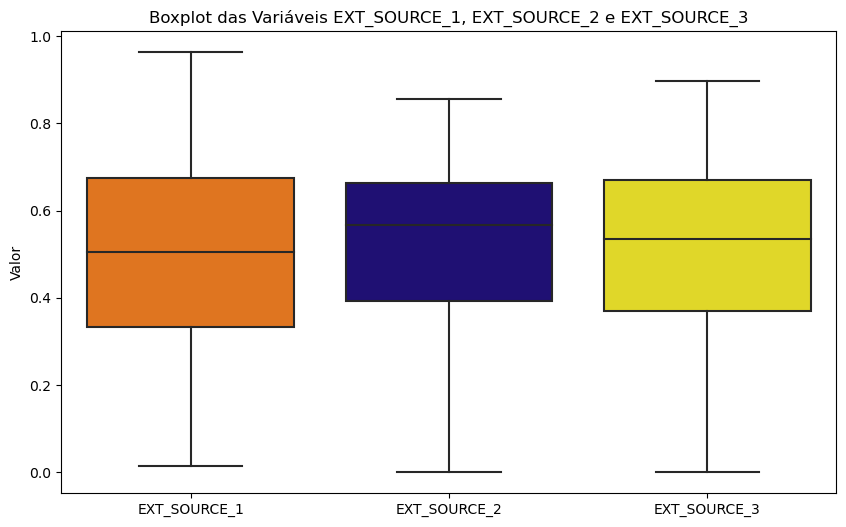

In [43]:
# Selecionar as colunas relevantes
ext_sources = df_app_train_plot[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# Criar um boxplot usando Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=ext_sources, palette = ['#FF7200', '#140083', '#FFF20A'])
plt.title('Boxplot daos scores externos')
plt.ylabel('Valor')
plt.show()